## simple single point coronavirus predictions
#### using jhu covid data

In [74]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

loading data

In [75]:
datapath = "../COVID-19/csse_covid_19_data/csse_covid_19_time_series/"

# Choose from "US Cases", "US Deaths", "World Cases", "World Deaths", "World Recoveries"
key = "World Cases" 

if key == "US Cases":
    datapath = datapath + "time_series_covid19_confirmed_US.csv"
elif key == "US Deaths":
    datapath = datapath + "time_series_covid19_deaths_US.csv"
elif key == "World Cases":
    datapath = datapath + "time_series_covid19_confirmed_global.csv"
elif key == "World Deaths":
    datapath = datapath + "time_series_covid19_deaths_global.csv"
elif key == "World Recoveries":
    datapath = datapath + "time_series_covid19_recovered_global.csv"

In [76]:
covid_df = pd.read_csv(datapath)

In [77]:
covid_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,15205,15750,16509,17267,18054,18969,19551,20342,20917,21459
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,1137,1143,1164,1184,1197,1212,1232,1246,1263,1299
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,9394,9513,9626,9733,9831,9935,10050,10154,10265,10382
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,764,765,844,851,852,852,852,852,852,852
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,86,86,86,86,86,86,88,91,92,96


In [78]:
abridged_covid_df = covid_df.loc[:,'3/22/20':]

In [79]:
abridged_covid_df.index

RangeIndex(start=0, stop=266, step=1)

In [80]:
abridged_covid_df.index = covid_df['Country/Region']

In [81]:
abridged_covid_df

,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,...,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,40,40,74,84,94,110,110,120,170,174,...,15205,15750,16509,17267,18054,18969,19551,20342,20917,21459
Albania,89,104,123,146,174,186,197,212,223,243,...,1137,1143,1164,1184,1197,1212,1232,1246,1263,1299
Algeria,201,230,264,302,367,409,454,511,584,716,...,9394,9513,9626,9733,9831,9935,10050,10154,10265,10382
Andorra,113,133,164,188,224,267,308,334,370,376,...,764,765,844,851,852,852,852,852,852,852
Angola,2,3,3,3,4,4,5,7,7,7,...,86,86,86,86,86,86,88,91,92,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sao Tome and Principe,0,0,0,0,0,0,0,0,0,0,...,483,484,484,484,485,499,499,513,513,514
Yemen,0,0,0,0,0,0,0,0,0,0,...,323,354,399,419,453,469,482,484,496,524
Comoros,0,0,0,0,0,0,0,0,0,0,...,106,106,132,132,132,132,141,141,141,141


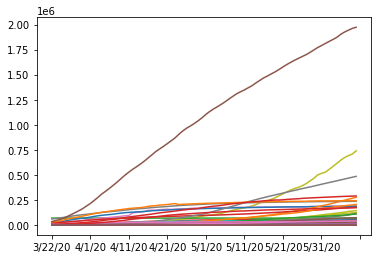

In [82]:
abridged_covid_df.T.plot(legend=False)

In [83]:
flattened_df = abridged_covid_df.to_numpy().flatten()
covid_data = flattened_df
num_regions = abridged_covid_df.shape[0]; print(num_regions)
num_days = abridged_covid_df.shape[1]; print(num_days)

266
80


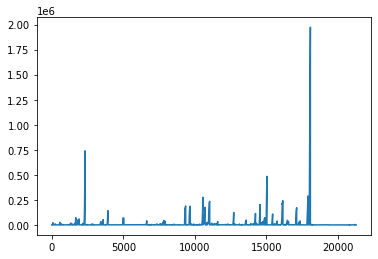

In [84]:
plt.plot(covid_data)

In [85]:
train_end_index = int(len(covid_data) * 0.8) ; train_end_index # about 70 percent for training

17024

In [86]:
# this code is directly from https://www.tensorflow.org/tutorials/structured_data/time_series

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
    
  return np.array(data), np.array(labels)

In [87]:
# time to scale these features and standardize using training data

train_data_mean = covid_data[:train_end_index].mean()
train_data_std = covid_data[:train_end_index].std()
print(train_data_mean, train_data_std)
covid_data = (covid_data - train_data_mean)/train_data_std

9837.040472274437 37026.42069756561


In [88]:
# choose {trig_past_history} vals to use to predict {trig_future_target + 1} vals into the future
covid_past_history = 20
covid_future_target = 0

x_train_trig, y_train_trig = univariate_data(covid_data, 0, train_end_index, covid_past_history, covid_future_target)

x_val_trig, y_val_trig = univariate_data(covid_data, train_end_index, None, covid_past_history, covid_future_target)

In [89]:
print(x_train_trig.shape, y_train_trig.shape)
print(x_train_trig.shape[-2:])

(17004, 20, 1) (17004,)
(20, 1)


In [90]:
print(x_val_trig.shape, y_val_trig.shape)

(4236, 20, 1) (4236,)


Past history example:
 [[-0.24687886]
 [-0.2466628 ]
 [-0.24641973]
 [-0.2463117 ]
 [-0.2463117 ]
 [-0.24614965]
 [-0.24614965]
 [-0.24593359]
 [-0.24574453]
 [-0.24574453]
 [-0.24560949]
 [-0.24560949]
 [-0.24560949]
 [-0.24555548]
 [-0.24555548]
 [-0.24550146]
 [-0.24547446]
 [-0.24542044]
 [-0.24539343]
 [-0.24539343]]
using this history to predict the val:  -0.245366424869465


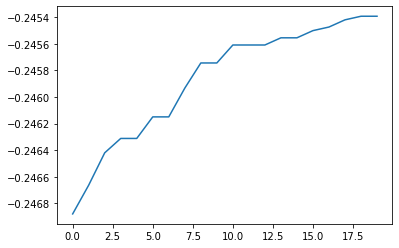

In [91]:
index = 266
print("Past history example:\n", x_train_trig[index])
print("using this history to predict the val: ", y_train_trig[index])
plt.plot(x_train_trig[index])

In [92]:
# much of below code is derived from https://www.tensorflow.org/tutorials/structured_data/time_series

BATCH_SIZE = num_days
BUFFER_SIZE = num_days * 10

train_trig = tf.data.Dataset.from_tensor_slices((x_train_trig, y_train_trig))
train_trig = train_trig.cache().batch(BATCH_SIZE).repeat()

val_trig = tf.data.Dataset.from_tensor_slices((x_val_trig, y_val_trig))
val_trig = val_trig.batch(BATCH_SIZE).repeat()

In [93]:
# creating the neural network model

lstm_prediction_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_trig.shape[-2:]),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

In [94]:
lstm_prediction_model.compile(optimizer='adam', loss='mae')

In [95]:
lstm_prediction_model.fit(train_trig, epochs=20, steps_per_epoch=150, validation_data=val_trig, validation_steps=50)

Train for 150 steps, validate for 50 steps
Epoch 1/20
150/150 [==============================] - 5s 36ms/step - loss: 0.1665 - val_loss: 0.5836
Epoch 2/20
150/150 [==============================] - 3s 18ms/step - loss: 0.0876 - val_loss: 0.5797
Epoch 3/20
150/150 [==============================] - 3s 18ms/step - loss: 0.0817 - val_loss: 0.5354
Epoch 4/20
150/150 [==============================] - 3s 18ms/step - loss: 0.0513 - val_loss: 0.5114
Epoch 5/20
150/150 [==============================] - 3s 18ms/step - loss: 0.0538 - val_loss: 0.4962
Epoch 6/20
150/150 [==============================] - 3s 18ms/step - loss: 0.0684 - val_loss: 0.4826
Epoch 7/20
150/150 [==============================] - 3s 18ms/step - loss: 0.0480 - val_loss: 0.4864
Epoch 8/20
150/150 [==============================] - 3s 18ms/step - loss: 0.0401 - val_loss: 0.4839
Epoch 9/20
150/150 [==============================] - 3s 18ms/step - loss: 0.0452 - val_loss: 0.4822
Epoch 10/20
150/150 [===========================

In [96]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

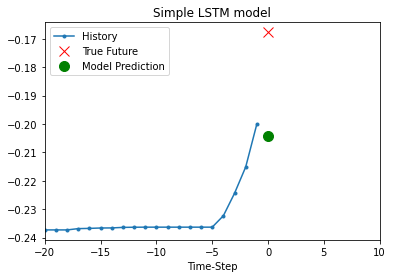

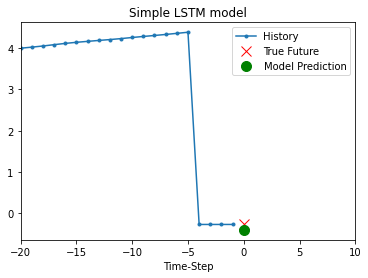

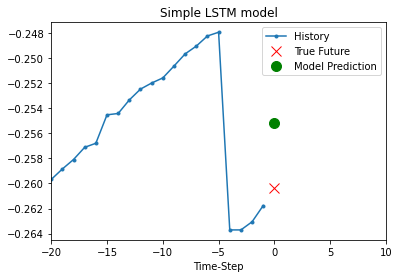

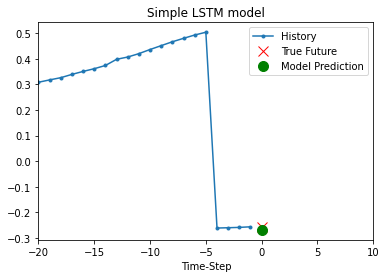

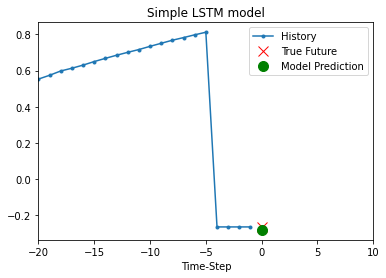

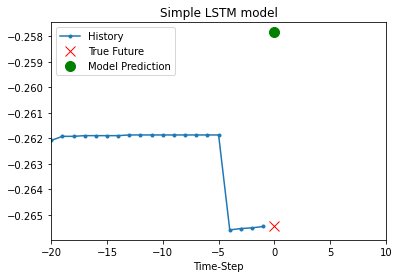

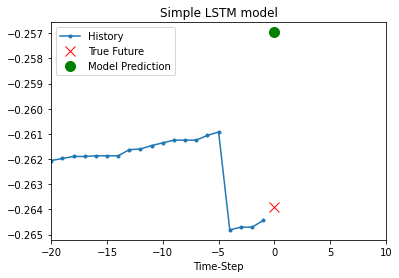

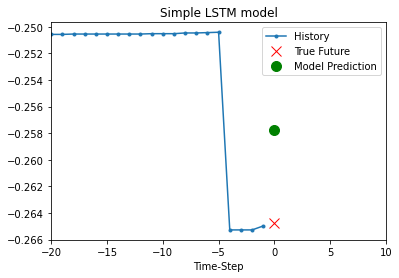

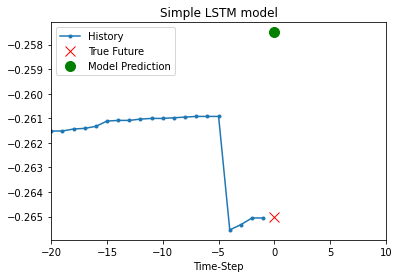

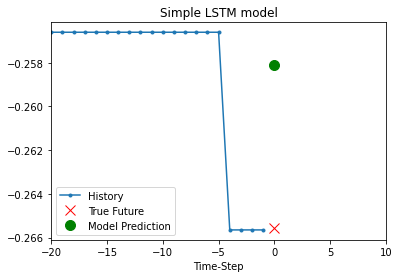

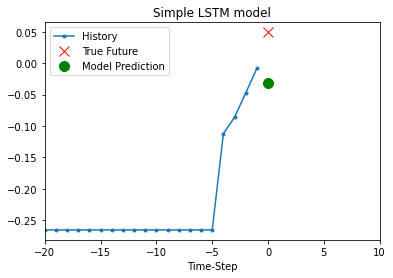

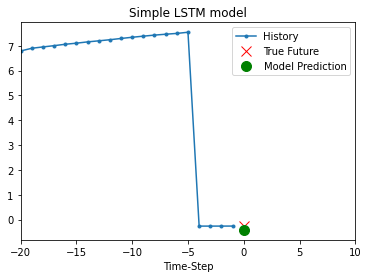

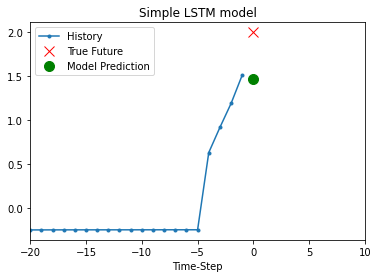

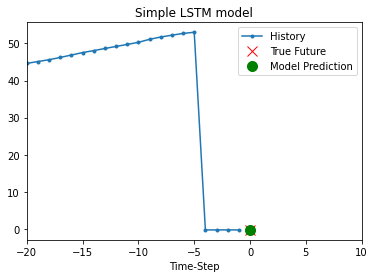

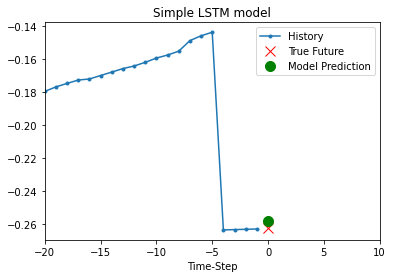

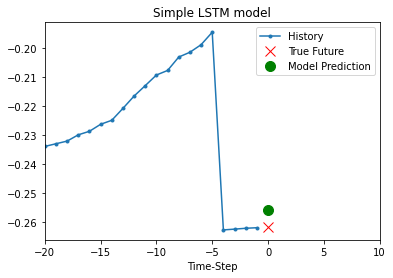

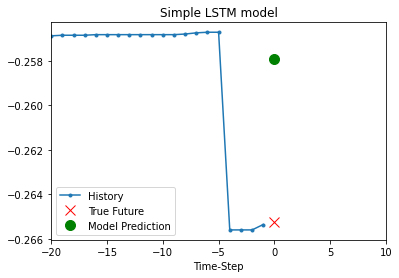

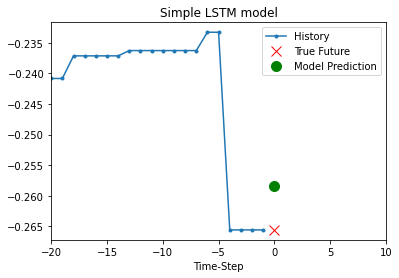

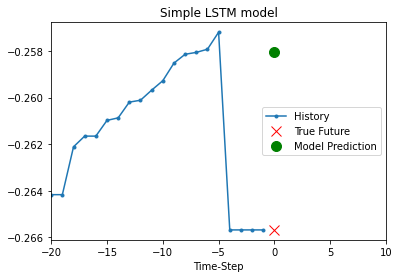

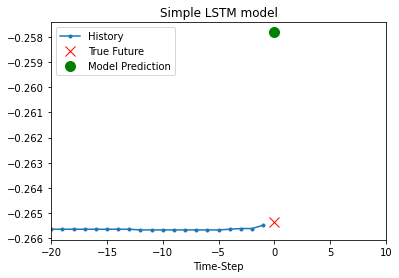

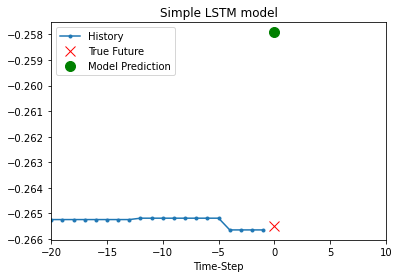

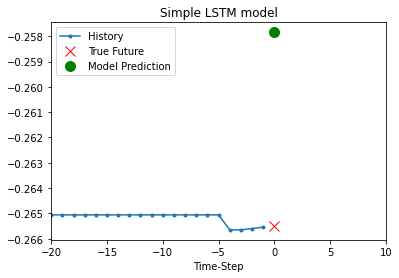

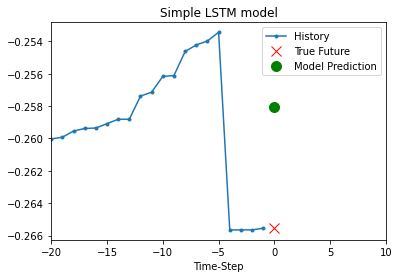

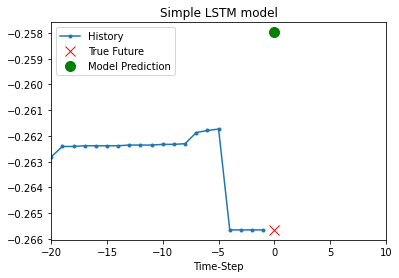

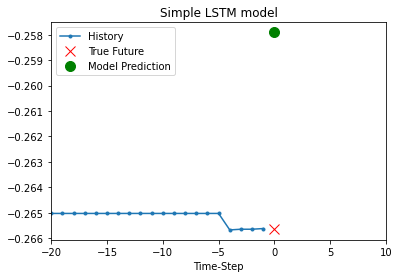

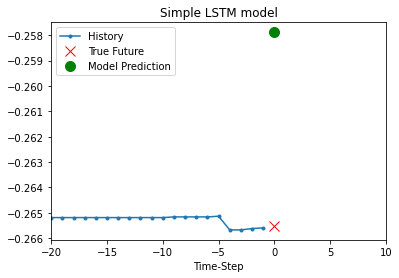

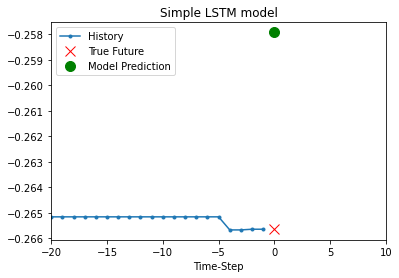

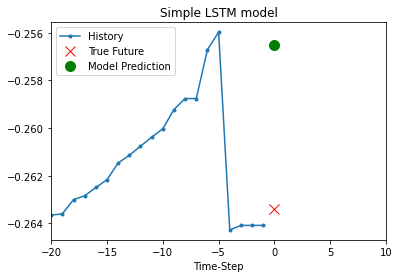

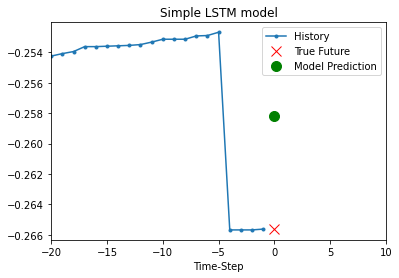

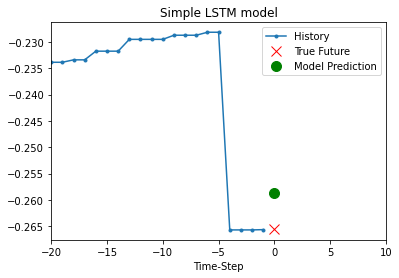

In [97]:
for x, y in val_trig.take(30):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    lstm_prediction_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()